In [1]:
import sys,os

data_path = os.getcwd()

try:
    import localgraphclustering as lgc
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    import localgraphclustering as lgc

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt

# Import the graph_tool module for visualization.
from graph_tool.all import * 

import statistics as stat_

# Load graph

In [3]:
# Read graph. This also supports gml format.
#g = lgc.GraphLocal(os.path.join(data_path,'datasets/JohnsHopkins.graphml'),'graphml')
g = lgc.GraphLocal(os.path.join(data_path,'datasets/Rice31_reduced.graphml'),'graphml')
# To get a quick look at the list of methods and attributes for the graph object 'g' you can type 'g.' + tab
# and scroll up or down.

vol_G = g.vol_G

/usr/local/lib/python3.7/site-packages/localgraphclustering/GraphLocal.py:217: UserWarning:

Loading a graphml is not efficient, we suggest using an edgelist format for this API.



## Load graph using GraphTool. We do this to handle some meta-data which LocalGraphClustering is not handling yet.

In [4]:
g_gtool = load_graph('datasets/Rice31_reduced.graphml')
remove_self_loops(g_gtool)

n = g_gtool.num_vertices()

## Load coordinates for graph layout

In [5]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(n):
    pos[i] = [xx[i],yy[i]]

## Load and filter ground truth clusters. This part takes a while to run. The results are saved in results/

In [6]:
g_v_prop = g_gtool.vertex_properties
#feature_list = [g_v_prop.secondMajor,g_v_prop.highSchool,g_v_prop.gender,g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]
feature_list = [g_v_prop.dorm,g_v_prop.majorIndex,g_v_prop.year]

number_feature = 0

ref_nodes = []
info_ref_nodes = []

for kk in feature_list:
    
    feature = kk

    for ff in list(set(feature.a)):
        
        if ff == 0:
            continue

        feature_array = np.zeros(n)
        feature_ff_nodes = []
        for i in range(n):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(n)) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        vol_ff = sum(g.d[feature_ff_nodes_largest_component])
        
        if vol_ff < 1000:
            continue
            
        #temp = np.zeros(n)
        #temp[feature_ff_nodes_largest_component] = 1
        
        #cut_ff = vol_ff - (g.adjacency_matrix.dot(temp).transpose()).dot(temp)
        #cond_ff = cut_ff/min(vol_ff,vol_G - vol_ff)
        cond_ff = g.compute_conductance(feature_ff_nodes_largest_component,cpp=True)
        
        if cond_ff > 0.47:
            continue
            
        print("Reached")
        eig_ff, lambda_ff = lgc.fiedler_local(g, feature_ff_nodes_largest_component)
        lambda_ff = np.real(lambda_ff)
        gap_ff = lambda_ff/cond_ff
        
        print("Number of feature", number_feature, "Feature value ", ff, " gap ",gap_ff, " volume: ", vol_ff, " size:", len(feature_ff_nodes_largest_component), "conductance: ", cond_ff)
        
        if gap_ff >= 0.5 and vol_ff >= 1000:
            ref_nodes.append(feature_ff_nodes_largest_component)
            info_ref_nodes.append([number_feature,ff])
            np.save('results/ref_nodes_Rice31', ref_nodes) 
            np.save('results/info_ref_nodes_Rice31', info_ref_nodes) 
        
    number_feature += 1

Reached
Number of feature 0 Feature value  203  gap  [0.83267026]  volume:  43321.0  size: 403 conductance:  0.46275478405392306
Reached
Number of feature 2 Feature value  2009  gap  [0.91440611]  volume:  30858.0  size: 607 conductance:  0.3385183744895975


## If you have generated the ground truth datasets once, you can avoid rerunning the above code and simple run the code below.

In [7]:
ref_nodes = np.load('results/ref_nodes_Rice31.npy') 
info_ref_nodes = np.load('results/info_ref_nodes_Rice31.npy') 

## Visualize the ground truth clusters

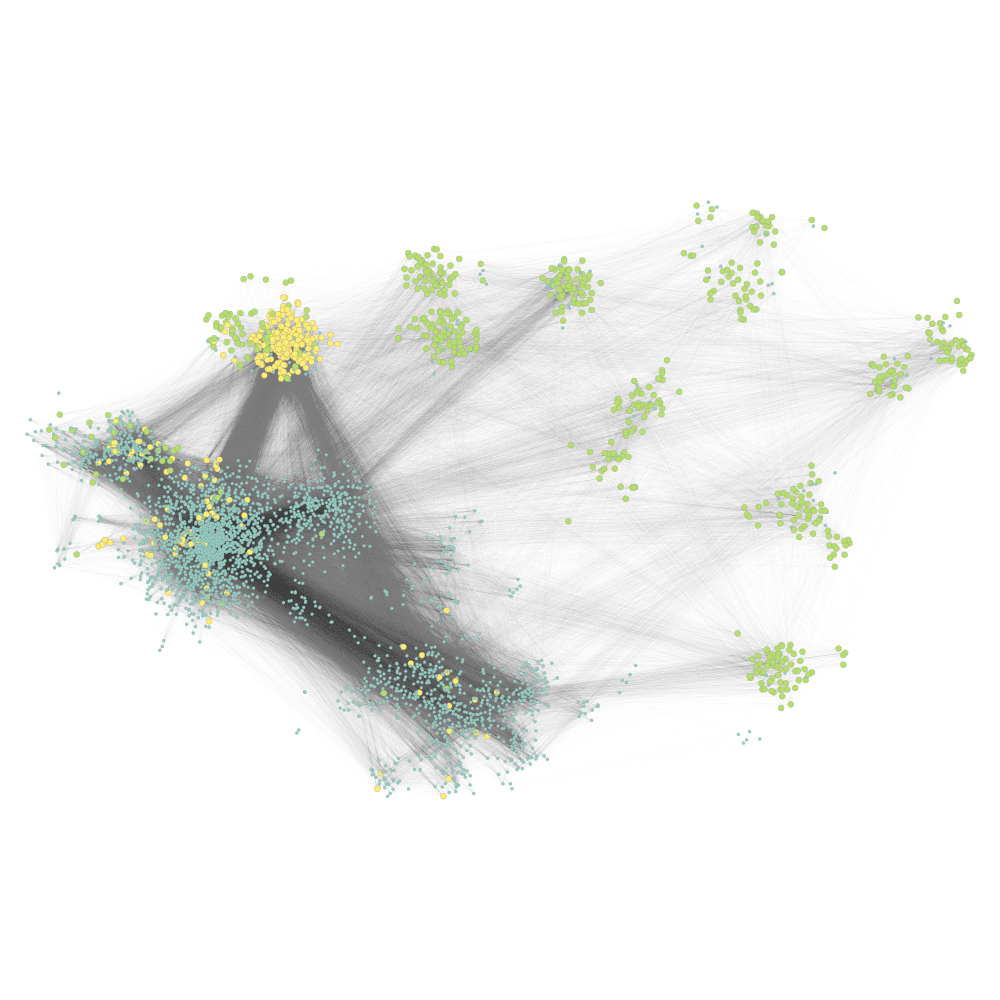

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x141fd8940, at 0x13dc99780>

In [8]:
temp = np.zeros(n)
temp = temp + 3

temp2 = np.zeros(n, dtype=int)

counter = 0

for i in ref_nodes:
        
    temp[i] = 6
    
    for j in i:
        temp2[j] = int(info_ref_nodes[counter,1])
    counter += 1

node_size = g_gtool.new_vertex_property("double",temp)

node_colours = g_gtool.new_vertex_property("int",temp2)

c_map = plt.get_cmap('Dark2')

graph_draw(g_gtool, pos, output_size=(1000, 1000),
            vertex_size=node_size, 
            vertex_fill_color=node_colours,
            edge_pen_width=0.1,
            edge_color = [0.0, 0, 0, 0.05]
            )

## Results by spectral algorithm: https://dl.acm.org/citation.cfm?id=1170528 

In [9]:
nodes = {}
external_best_cond_acl = {}
external_best_pre_cond_acl = {}
gap_best_cond_acl = {}
gap_best_pre_acl = {}
vol_best_cond_acl = {}
vol_best_pre_acl = {}
size_clust_best_cond_acl = {}
size_clust_best_pre_acl = {}
f1score_best_cond_acl = {}
f1score_best_pre_acl = {}
true_positives_best_cond_acl = {}
true_positives_best_pre_acl = {}
precision_best_cond_acl = {}
precision_best_pre_acl = {}
recall_best_cond_acl = {}
recall_best_pre_acl = {}
cuts_best_cond_acl = {}
cuts_best_pre_acl = {}
cuts_acl_ALL = {}

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)
    
    nodes[ct_outer] = np.random.choice(rr, how_many, replace=False)
    
    eigv, lambda_val = lgc.fiedler_local(g, rr)
    lambda_val = np.real(lambda_val)
    
    step = (2*lambda_val - lambda_val/2)/4
    
    a_list = np.arange(lambda_val/2,2*lambda_val,step)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        max_precision = -1
        min_conduct = 100
        
        ct_inner = 0
        for a in a_list:

            output_pr_clustering = lgc.spectral_clustering(g,ref_node,method="l1reg",alpha=a,rho=2.0e-7,epsilon=1.0e-2,iterations=1000)
            
            S_l1pr = output_pr_clustering[0]
            
            cuts_acl_ALL[ct_outer,node,ct_inner] = S_l1pr
            
            size_clust_acl_ = len(S_l1pr)
            
            cond_val_l1pr = output_pr_clustering[1]
            
            vol_ = sum(g.d[S_l1pr])
            true_positives_acl_ = set(rr).intersection(S_l1pr)
            if len(true_positives_acl_) == 0:
                true_positives_acl_ = set(ref_node)
                vol_ = g.d[ref_node][0,0]
            precision = sum(g.d[np.array(list(true_positives_acl_))])/vol_
            recall = sum(g.d[np.array(list(true_positives_acl_))])/sum(g.d[rr])
            f1_score_ = 2*(precision*recall)/(precision + recall)
            
            if f1_score_ >= max_precision:
            
                max_precision = f1_score_
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_pre_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_pre_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_pre_acl[ct_outer,node] = vol_

                size_clust_best_pre_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_pre_acl[ct_outer,node] = true_positives_acl_
                precision_best_pre_acl[ct_outer,node] = precision
                recall_best_pre_acl[ct_outer,node] = recall
                f1score_best_pre_acl[ct_outer,node] = f1_score_
                
                cuts_best_pre_acl[ct_outer,node] = S_l1pr
                
            if cond_val_l1pr <= min_conduct:
            
                min_conduct = cond_val_l1pr
            
                S_smqi, S_smqi_val = lgc.fiedler_local(g, S_l1pr)
                S_smqi_val = np.real(S_smqi_val)

                external_best_cond_acl[ct_outer,node] = cond_val_l1pr
                gap_best_cond_acl[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_l1pr])))/cond_val_l1pr
                vol_best_cond_acl[ct_outer,node] = vol_

                size_clust_best_cond_acl[ct_outer,node] = size_clust_acl_
                true_positives_best_cond_acl[ct_outer,node] = true_positives_acl_
                precision_best_cond_acl[ct_outer,node] = precision
                recall_best_cond_acl[ct_outer,node] = recall
                f1score_best_cond_acl[ct_outer,node] = f1_score_
                
                cuts_best_cond_acl[ct_outer,node] = S_l1pr

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', external_best_cond_acl[ct_outer,node], 'f1score: ', f1score_best_pre_acl[ct_outer,node], 'precision: ', precision_best_pre_acl[ct_outer,node], 'recall: ', recall_best_pre_acl[ct_outer,node])
        ct += 1
    ct_outer += 1
    
    np.save('results/size_clust_best_cond_acl_Rice31', size_clust_best_cond_acl) 
    np.save('results/external_best_cond_acl_Rice31', external_best_cond_acl)
    np.save('results/vol_best_cond_acl_Rice31', vol_best_cond_acl) 
    np.save('results/gap_best_cond_acl_Rice31', gap_best_cond_acl) 
    np.save('results/cuts_best_cond_acl_Rice31', cuts_best_cond_acl) 
    np.save('results/true_positives_best_cond_acl_Rice31', true_positives_best_cond_acl)
    np.save('results/f1score_best_cond_acl_Rice31', f1score_best_cond_acl) 
    np.save('results/precision_best_cond_acl_Rice31', precision_best_cond_acl) 
    np.save('results/recall_best_cond_acl_Rice31', recall_best_cond_acl) 

    np.save('results/size_clust_best_pre_acl_Rice31', size_clust_best_pre_acl) 
    np.save('results/external_best_pre_cond_acl_Rice31', external_best_pre_cond_acl)
    np.save('results/vol_best_pre_acl_Rice31', vol_best_pre_acl) 
    np.save('results/gap_best_pre_acl_Rice31', gap_best_pre_acl) 
    np.save('results/cuts_best_pre_acl_Rice31', cuts_best_pre_acl) 
    np.save('results/true_positives_best_pre_acl_Rice31', true_positives_best_pre_acl)
    np.save('results/f1score_best_pre_acl_Rice31', f1score_best_pre_acl) 
    np.save('results/precision_best_pre_acl_Rice31', precision_best_pre_acl) 
    np.save('results/recall_best_pre_acl_Rice31', recall_best_pre_acl) 

    np.save('results/cuts_acl_ALL_Rice31', cuts_acl_ALL) 
    
    np.save('results/nodes_Rice31', nodes)

201
outer: 0 number of node:  1449  completed:  0.0  degree:  79.0
conductance:  0.3256092083403233 f1score:  0.6083051026381705 precision:  0.5205814717477004 recall:  0.7315851434639089
outer: 0 number of node:  2613  completed:  0.004975124378109453  degree:  191.0
conductance:  0.36256920653991653 f1score:  0.732744767384188 precision:  0.6424533388996155 recall:  0.8525657302463009
outer: 0 number of node:  1935  completed:  0.009950248756218905  degree:  179.0
conductance:  0.34395462859740455 f1score:  0.6413091050558428 precision:  0.49416070246437094 recall:  0.9132522333279471
outer: 0 number of node:  1688  completed:  0.014925373134328358  degree:  110.0
conductance:  0.3152282175645245 f1score:  0.3066650916019949 precision:  0.19721231338353812 recall:  0.6891345998476489
outer: 0 number of node:  390  completed:  0.01990049751243781  degree:  110.0
conductance:  0.29550571527537234 f1score:  0.5111313107230137 precision:  0.37736949227130206 recall:  0.7917868931926779
o

outer: 0 number of node:  1481  completed:  0.20398009950248755  degree:  56.0
conductance:  0.2940202571094663 f1score:  0.3657352161230443 precision:  0.2852839653010304 recall:  0.509383439902126
outer: 0 number of node:  3848  completed:  0.208955223880597  degree:  44.0
conductance:  0.3304663846657965 f1score:  0.5683802324780268 precision:  0.49543582704186684 recall:  0.6665127767133723
outer: 0 number of node:  1764  completed:  0.21393034825870647  degree:  125.0
conductance:  0.3328571660471081 f1score:  0.5843568309202326 precision:  0.46945378151260503 recall:  0.7737356016712449
outer: 0 number of node:  1093  completed:  0.21890547263681592  degree:  3.0
conductance:  0.31829495281793785 f1score:  0.31483875445735254 precision:  0.25221718702215795 recall:  0.4188268968860368
outer: 0 number of node:  2603  completed:  0.22388059701492538  degree:  35.0
conductance:  0.3238134919131851 f1score:  0.49096767114542494 precision:  0.4322852626031969 recall:  0.56808476258627

outer: 0 number of node:  2273  completed:  0.4079601990049751  degree:  119.0
conductance:  0.32981952974918155 f1score:  0.5748978596255869 precision:  0.4291632051530084 recall:  0.8705016043027631
outer: 0 number of node:  3562  completed:  0.4129353233830846  degree:  58.0
conductance:  0.3350575707730932 f1score:  0.42871435341552766 precision:  0.3179789323335119 recall:  0.6577872163615799
outer: 0 number of node:  51  completed:  0.417910447761194  degree:  76.0
conductance:  0.3442316017316017 f1score:  0.7588784573086522 precision:  0.8410941976071449 recall:  0.6913044481891
outer: 0 number of node:  2975  completed:  0.4228855721393035  degree:  123.0
conductance:  0.3291259140582291 f1score:  0.5356639635822602 precision:  0.4673016091321689 recall:  0.6274555065672538
outer: 0 number of node:  2041  completed:  0.42786069651741293  degree:  17.0
conductance:  0.33945539946752096 f1score:  0.5678014677554242 precision:  0.47881141045958797 recall:  0.6974215738325523
oute

outer: 0 number of node:  1588  completed:  0.6169154228855721  degree:  106.0
conductance:  0.30720368787265584 f1score:  0.3900452934226073 precision:  0.247892665160608 recall:  0.9144064079776552
outer: 0 number of node:  967  completed:  0.6218905472636815  degree:  34.0
conductance:  0.335570542451043 f1score:  0.6377481779341543 precision:  0.5648751647255761 recall:  0.7322083977747513
outer: 0 number of node:  40  completed:  0.6268656716417911  degree:  85.0
conductance:  0.3253150305287317 f1score:  0.3021075905204664 precision:  0.2375776808144916 recall:  0.4147642021190647
outer: 0 number of node:  2641  completed:  0.6318407960199005  degree:  108.0
conductance:  0.3547761452780306 f1score:  0.7946698970321018 precision:  0.7598348917530116 recall:  0.8328524272292883
outer: 0 number of node:  2310  completed:  0.6368159203980099  degree:  52.0
conductance:  0.31373812295281667 f1score:  0.40944307720353657 precision:  0.294032345773499 recall:  0.67399182844348
outer: 0

outer: 0 number of node:  2172  completed:  0.8258706467661692  degree:  38.0
conductance:  0.3048547473030685 f1score:  0.28994072463259796 precision:  0.17896052866583317 recall:  0.7632787793448905
outer: 0 number of node:  3803  completed:  0.8308457711442786  degree:  17.0
conductance:  0.3557208949974297 f1score:  0.59438724947242 precision:  0.600499434602337 recall:  0.5883982364211352
outer: 0 number of node:  955  completed:  0.835820895522388  degree:  133.0
conductance:  0.35404015803431294 f1score:  0.6861599120710409 precision:  0.5514814139686189 recall:  0.9078737794603079
outer: 0 number of node:  555  completed:  0.8407960199004975  degree:  99.0
conductance:  0.34173351086285847 f1score:  0.7399558609620304 precision:  0.8099761166167952 recall:  0.6810784607926872
outer: 0 number of node:  973  completed:  0.845771144278607  degree:  238.0
conductance:  0.3466541141843051 f1score:  0.6017065655368572 precision:  0.4574108998306286 recall:  0.878996329724614
outer: 0

outer: 1 number of node:  2438  completed:  0.0231023102310231  degree:  65.0
conductance:  0.30741422231843274 f1score:  0.34513547356768237 precision:  0.21217395184862886 recall:  0.9244604316546763
outer: 1 number of node:  1312  completed:  0.026402640264026403  degree:  59.0
conductance:  0.3136881099641468 f1score:  0.4623735464882513 precision:  0.3074890904423719 recall:  0.9316546762589928
outer: 1 number of node:  1053  completed:  0.0297029702970297  degree:  9.0
conductance:  0.2909860466123253 f1score:  0.45182646532464643 precision:  0.35350965498306947 recall:  0.6258992805755396
outer: 1 number of node:  2749  completed:  0.033003300330033  degree:  111.0
conductance:  0.3210231425091352 f1score:  0.3515675648457612 precision:  0.2181551175997313 recall:  0.9050489338259122
outer: 1 number of node:  2710  completed:  0.036303630363036306  degree:  204.0
conductance:  0.3058090073708478 f1score:  0.34759925922580065 precision:  0.2104694572456138 recall:  0.997537105450

outer: 1 number of node:  974  completed:  0.15841584158415842  degree:  32.0
conductance:  0.3259175056836635 f1score:  0.3053753969212408 precision:  0.19555466596307988 recall:  0.696545466329639
outer: 1 number of node:  3640  completed:  0.1617161716171617  degree:  82.0
conductance:  0.2989225432525015 f1score:  0.8011632133769538 precision:  0.7265870190152175 recall:  0.8927992740942381
outer: 1 number of node:  1373  completed:  0.16501650165016502  degree:  24.0
conductance:  0.3123551956347574 f1score:  0.3714469361519782 precision:  0.2382239240761437 recall:  0.8427312204290621
outer: 1 number of node:  507  completed:  0.16831683168316833  degree:  23.0
conductance:  0.31521556785774196 f1score:  0.31375066125903717 precision:  0.20051930722973033 recall:  0.7207531272279474
outer: 1 number of node:  608  completed:  0.1716171617161716  degree:  29.0
conductance:  0.30757072177895184 f1score:  0.30161494957314583 precision:  0.19363834663279675 recall:  0.6818005055415127

outer: 1 number of node:  420  completed:  0.29372937293729373  degree:  48.0
conductance:  0.30873918906477626 f1score:  0.4174108962624234 precision:  0.2705897049073211 recall:  0.9125672435024953
outer: 1 number of node:  967  completed:  0.297029702970297  degree:  34.0
conductance:  0.33314568425155083 f1score:  0.2859274776611917 precision:  0.16682169704180413 recall:  0.9996435284205069
outer: 1 number of node:  635  completed:  0.30033003300330036  degree:  77.0
conductance:  0.30582555798497607 f1score:  0.3769398095339152 precision:  0.2369632285499875 recall:  0.920960528874198
outer: 1 number of node:  2195  completed:  0.30363036303630364  degree:  51.0
conductance:  0.32176878112145485 f1score:  0.4414570491705765 precision:  0.2864531568129843 recall:  0.9620195735303649
outer: 1 number of node:  67  completed:  0.3069306930693069  degree:  85.0
conductance:  0.3119831132279714 f1score:  0.3468675810748843 precision:  0.21127696735279766 recall:  0.9682740294251085
out

outer: 1 number of node:  1698  completed:  0.429042904290429  degree:  50.0
conductance:  0.32410314144060276 f1score:  0.3609965793809432 precision:  0.2432843728511684 recall:  0.6993972389655843
outer: 1 number of node:  3080  completed:  0.43234323432343236  degree:  10.0
conductance:  0.31490379412592256 f1score:  0.3045784387100973 precision:  0.18289823354697515 recall:  0.9099747229243632
outer: 1 number of node:  3405  completed:  0.43564356435643564  degree:  46.0
conductance:  0.31002232481522424 f1score:  0.7553415985228172 precision:  0.7687764279481845 recall:  0.7423682675481237
outer: 1 number of node:  625  completed:  0.4389438943894389  degree:  46.0
conductance:  0.3287686062246279 f1score:  0.40748001809681794 precision:  0.25839824732229794 recall:  0.9631862077905243
outer: 1 number of node:  860  completed:  0.44224422442244227  degree:  108.0
conductance:  0.31724317070003033 f1score:  0.25821674593682487 precision:  0.15065995888780698 recall:  0.902553632769

outer: 1 number of node:  2813  completed:  0.5643564356435643  degree:  78.0
conductance:  0.3143367333134926 f1score:  0.7257197434847863 precision:  0.6267439668174962 recall:  0.8618186531855596
outer: 1 number of node:  3379  completed:  0.5676567656765676  degree:  51.0
conductance:  0.3096002555592253 f1score:  0.3563651259282751 precision:  0.22381284336669488 recall:  0.8739710933955538
outer: 1 number of node:  226  completed:  0.570957095709571  degree:  78.0
conductance:  0.3038998706716955 f1score:  0.36975789507709217 precision:  0.23095124649712906 recall:  0.9267612936677685
outer: 1 number of node:  1703  completed:  0.5742574257425742  degree:  61.0
conductance:  0.3175567809772227 f1score:  0.3420191765369431 precision:  0.209366391184573 recall:  0.9334370341564586
outer: 1 number of node:  3575  completed:  0.5775577557755776  degree:  17.0
conductance:  0.3218695028551325 f1score:  0.33772568894520116 precision:  0.2234704785060049 recall:  0.6910363601011082
oute

outer: 1 number of node:  3809  completed:  0.7029702970297029  degree:  43.0
conductance:  0.3034030251518531 f1score:  0.7763302041022703 precision:  0.8088147497805093 recall:  0.7463542679370018
outer: 1 number of node:  1270  completed:  0.7062706270627063  degree:  18.0
conductance:  0.3163736829274899 f1score:  0.33422386679000926 precision:  0.2165690007384887 recall:  0.7317713396850087
outer: 1 number of node:  2985  completed:  0.7095709570957096  degree:  110.0
conductance:  0.30542247917241827 f1score:  0.3546313891141477 precision:  0.21803190856054291 recall:  0.9495106617408776
outer: 1 number of node:  334  completed:  0.7128712871287128  degree:  66.0
conductance:  0.31976523838915416 f1score:  0.378150673447717 precision:  0.2410362823504266 recall:  0.8770821180893124
outer: 1 number of node:  3364  completed:  0.7161716171617162  degree:  91.0
conductance:  0.3135540388900032 f1score:  0.34325867894626677 precision:  0.21046957618604106 recall:  0.9300343508976603


outer: 1 number of node:  3220  completed:  0.8415841584158416  degree:  44.0
conductance:  0.31234300563014294 f1score:  0.3433619962906761 precision:  0.21679995230673582 recall:  0.8249400479616307
outer: 1 number of node:  2041  completed:  0.8448844884488449  degree:  17.0
conductance:  0.33392142006710684 f1score:  0.2837157558058684 precision:  0.16553615474490457 recall:  0.991736340657204
outer: 1 number of node:  627  completed:  0.8481848184818482  degree:  31.0
conductance:  0.31107647007880834 f1score:  0.31554951301555306 precision:  0.19260430378297946 recall:  0.8724803940631278
outer: 1 number of node:  1767  completed:  0.8514851485148515  degree:  3.0
conductance:  0.30236131852909987 f1score:  0.6061363382795939 precision:  0.46219288096372424 recall:  0.8802903623047508
outer: 1 number of node:  1288  completed:  0.8547854785478548  degree:  65.0
conductance:  0.3290626268091438 f1score:  0.36471012997730556 precision:  0.2276451555784492 recall:  0.916585650398600

outer: 1 number of node:  2381  completed:  0.9801980198019802  degree:  72.0
conductance:  0.31885837954822127 f1score:  0.414396820266674 precision:  0.2630081265329993 recall:  0.9764404692462246
outer: 1 number of node:  2626  completed:  0.9834983498349835  degree:  39.0
conductance:  0.3084081809327995 f1score:  0.30726709253051676 precision:  0.19088894477100557 recall:  0.7871864670425821
outer: 1 number of node:  1826  completed:  0.9867986798679867  degree:  101.0
conductance:  0.3200184027495873 f1score:  0.36811924531032364 precision:  0.22613623735970664 recall:  0.9892086330935251
outer: 1 number of node:  496  completed:  0.9900990099009901  degree:  22.0
conductance:  0.31988138913238745 f1score:  0.43686665059479773 precision:  0.2937999664560854 recall:  0.8515133838874847
outer: 1 number of node:  2035  completed:  0.9933993399339934  degree:  113.0
conductance:  0.30772020416889945 f1score:  0.320954276073885 precision:  0.1926167265930243 recall:  0.961760321472551

## Improve the results found by the spectral algorithm using MQI

In [10]:
nodes = np.load('results/nodes_Rice31.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Rice31.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="mqi")
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_mqi_Rice31', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_mqi_Rice31', external_cond_acl_flow)
    np.save('results/vol_acl_flow_mqi_Rice31', vol_acl_flow) 
    np.save('results/gap_acl_flow_mqi_Rice31', gap_acl_flow) 
    np.save('results/cuts_acl_flow_mqi_Rice31', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_mqi_Rice31', true_positives_acl_flow)
    np.save('results/recall_acl_flow_mqi_Rice31', recall_acl_flow) 
    np.save('results/precision_acl_flow_mqi_Rice31', precision_acl_flow) 
    np.save('results/f1score_acl_flow_mqi_Rice31', f1score_acl_flow) 

201
outer: 0 number of node:  1449  completed:  0.0  degree:  79.0
conductance:  0.3045598634479395 f1score:  0.10941953788963471 precision:  0.12695074372104365 recall:  0.09614274832067589
outer: 0 number of node:  2613  completed:  0.004975124378109453  degree:  191.0
conductance:  0.36158688732248256 f1score:  0.3777155674873715 precision:  0.23352861846236167 recall:  0.987304078853212
outer: 0 number of node:  1935  completed:  0.009950248756218905  degree:  179.0
conductance:  0.3421114791560236 f1score:  0.37453186844393954 precision:  0.23182984239987256 recall:  0.9741926548325293
outer: 0 number of node:  1688  completed:  0.014925373134328358  degree:  110.0
conductance:  0.31327568836287545 f1score:  0.30589327892055523 precision:  0.1896250124552993 recall:  0.7907250525149465
outer: 0 number of node:  390  completed:  0.01990049751243781  degree:  110.0
conductance:  0.295207143361793 f1score:  0.35150709999824037 precision:  0.21713232936419516 recall:  0.92225479559566

outer: 0 number of node:  1481  completed:  0.20398009950248755  degree:  56.0
conductance:  0.2921866253992295 f1score:  0.32070477550133675 precision:  0.1984733243335199 recall:  0.8348606911197802
outer: 0 number of node:  3848  completed:  0.208955223880597  degree:  44.0
conductance:  0.30339872055301215 f1score:  0.10916858880268401 precision:  0.12627717308916714 recall:  0.09614274832067589
outer: 0 number of node:  1764  completed:  0.21393034825870647  degree:  125.0
conductance:  0.3313216123924952 f1score:  0.3746883237158937 precision:  0.23211655477158508 recall:  0.9712610512222709
outer: 0 number of node:  1093  completed:  0.21890547263681592  degree:  3.0
conductance:  0.31694391608852923 f1score:  0.2999285165632895 precision:  0.18567831737270898 recall:  0.779668059370744
outer: 0 number of node:  2603  completed:  0.22388059701492538  degree:  35.0
conductance:  0.30361050328227573 f1score:  0.1092817317153165 precision:  0.12658035497203987 recall:  0.0961427483

outer: 0 number of node:  2273  completed:  0.4079601990049751  degree:  119.0
conductance:  0.3291492481778984 f1score:  0.36408834158273506 precision:  0.22519643677909343 recall:  0.9500242376676439
outer: 0 number of node:  3562  completed:  0.4129353233830846  degree:  58.0
conductance:  0.3340287031171498 f1score:  0.3400857633690607 precision:  0.21027108499530353 recall:  0.8888068142471319
outer: 0 number of node:  51  completed:  0.417910447761194  degree:  76.0
conductance:  0.34272227896320423 f1score:  0.36827707880386357 precision:  0.22817787837800535 recall:  0.9540638489416219
outer: 0 number of node:  2975  completed:  0.4228855721393035  degree:  123.0
conductance:  0.30344304565448205 f1score:  0.10919434758671316 precision:  0.12634612467768846 recall:  0.09614274832067589
outer: 0 number of node:  2041  completed:  0.42786069651741293  degree:  17.0
conductance:  0.3107932379713914 f1score:  0.11015750009918142 precision:  0.12895535327264845 recall:  0.0961427483

outer: 0 number of node:  3007  completed:  0.6119402985074627  degree:  50.0
conductance:  0.30347987014957073 f1score:  0.10920007341181406 precision:  0.12636145748005218 recall:  0.09614274832067589
outer: 0 number of node:  1588  completed:  0.6169154228855721  degree:  106.0
conductance:  0.30347987014957073 f1score:  0.10920007341181406 precision:  0.12636145748005218 recall:  0.09614274832067589
outer: 0 number of node:  967  completed:  0.6218905472636815  degree:  34.0
conductance:  0.3037428606148985 f1score:  0.10926453034615739 precision:  0.1265342082877628 recall:  0.09614274832067589
outer: 0 number of node:  40  completed:  0.6268656716417911  degree:  85.0
conductance:  0.3236046966085554 f1score:  0.28509582903673153 precision:  0.17654117789533366 recall:  0.7403107038157014
outer: 0 number of node:  2641  completed:  0.6318407960199005  degree:  108.0
conductance:  0.3522013961413731 f1score:  0.37424029194099023 precision:  0.23167701863354037 recall:  0.972946146

outer: 0 number of node:  1451  completed:  0.8159203980099502  degree:  19.0
conductance:  0.3042601923957856 f1score:  0.10951016222753923 precision:  0.12719499160177125 recall:  0.09614274832067589
outer: 0 number of node:  2591  completed:  0.8208955223880597  degree:  297.0
conductance:  0.3094598043847787 f1score:  0.34934801150102435 precision:  0.21576869396156123 recall:  0.917130260150966
outer: 0 number of node:  2172  completed:  0.8258706467661692  degree:  38.0
conductance:  0.30244680437234994 f1score:  0.29229184395574864 precision:  0.18132915437151637 recall:  0.7532143763994368
outer: 0 number of node:  3803  completed:  0.8308457711442786  degree:  17.0
conductance:  0.305011292193127 f1score:  0.10947993744003574 precision:  0.12711347128120612 recall:  0.09614274832067589
outer: 0 number of node:  955  completed:  0.835820895522388  degree:  133.0
conductance:  0.3520207025657967 f1score:  0.3768454839268964 precision:  0.23336636934258342 recall:  0.978370767064

outer: 1 number of node:  1010  completed:  0.013201320132013201  degree:  21.0
conductance:  0.303419192378872 f1score:  0.95868001692286 precision:  0.9280968417220351 recall:  0.9913474625704841
outer: 1 number of node:  1802  completed:  0.0165016501650165  degree:  76.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  104  completed:  0.019801980198019802  degree:  51.0
conductance:  0.30349073484365996 f1score:  0.9584997885040184 precision:  0.9277590756073151 recall:  0.9913474625704841
outer: 1 number of node:  2438  completed:  0.0231023102310231  degree:  65.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  1312  completed:  0.026402640264026403  degree:  59.0
conductance:  0.3033851007037127 f1score:  0.9585748754426097 precision:  0.9278997816064062 recall:  0.9913474625704841


outer: 1 number of node:  2407  completed:  0.15181518151815182  degree:  41.0
conductance:  0.30344304565448205 f1score:  0.9586199332529025 precision:  0.9279842256939178 recall:  0.9913474625704841
outer: 1 number of node:  3191  completed:  0.1551155115511551  degree:  34.0
conductance:  0.3033959975742874 f1score:  0.9583946865503306 precision:  0.9275621588841723 recall:  0.9913474625704841
outer: 1 number of node:  974  completed:  0.15841584158415842  degree:  32.0
conductance:  0.30344032522298403 f1score:  0.9586649952992793 precision:  0.9280686851526 recall:  0.9913474625704841
outer: 1 number of node:  3640  completed:  0.1617161716171617  degree:  82.0
conductance:  0.2973104593248478 f1score:  0.2917214191852825 precision:  0.17076923076923076 recall:  1.0
outer: 1 number of node:  1373  completed:  0.16501650165016502  degree:  24.0
conductance:  0.3034171189472727 f1score:  0.9583796738670719 precision:  0.9275340347472787 recall:  0.9913474625704841
outer: 1 number of

outer: 1 number of node:  4023  completed:  0.29042904290429045  degree:  60.0
conductance:  0.3027568723308927 f1score:  0.2978844585169489 precision:  0.17500836532953726 recall:  1.0
outer: 1 number of node:  420  completed:  0.29372937293729373  degree:  48.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  967  completed:  0.297029702970297  degree:  34.0
conductance:  0.3037032536379378 f1score:  0.9589964719717756 precision:  0.9290032505999939 recall:  0.990990990990991
outer: 1 number of node:  635  completed:  0.30033003300330036  degree:  77.0
conductance:  0.3029232323570619 f1score:  0.29284459237461247 precision:  0.17164291575263324 recall:  0.9965000972195217
outer: 1 number of node:  2195  completed:  0.30363036303630364  degree:  51.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of

outer: 1 number of node:  1698  completed:  0.429042904290429  degree:  50.0
conductance:  0.30349497464549235 f1score:  0.9591008135943941 precision:  0.9288859198979746 recall:  0.9913474625704841
outer: 1 number of node:  3080  completed:  0.43234323432343236  degree:  10.0
conductance:  0.3058230169646951 f1score:  0.9550909977506175 precision:  0.9279841051505425 recall:  0.983829152893901
outer: 1 number of node:  3405  completed:  0.43564356435643564  degree:  46.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  625  completed:  0.4389438943894389  degree:  46.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  860  completed:  0.44224422442244227  degree:  108.0
conductance:  0.3157287569491749 f1score:  0.26164194387817413 precision:  0.15299720934320685 recall:  0.9025536327694601
o

outer: 1 number of node:  3379  completed:  0.5676567656765676  degree:  51.0
conductance:  0.3033959975742874 f1score:  0.9583946865503306 precision:  0.9275621588841723 recall:  0.9913474625704841
outer: 1 number of node:  226  completed:  0.570957095709571  degree:  78.0
conductance:  0.3005213996932943 f1score:  0.29362983685645366 precision:  0.17207862818904224 recall:  1.0
outer: 1 number of node:  1703  completed:  0.5742574257425742  degree:  61.0
conductance:  0.30344304565448205 f1score:  0.9586199332529025 precision:  0.9279842256939178 recall:  0.9913474625704841
outer: 1 number of node:  3575  completed:  0.5775577557755776  degree:  17.0
conductance:  0.30353512365346685 f1score:  0.9586447902465015 precision:  0.9281444393870429 recall:  0.9912178365415776
outer: 1 number of node:  3154  completed:  0.5808580858085809  degree:  53.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of

outer: 1 number of node:  1270  completed:  0.7062706270627063  degree:  18.0
conductance:  0.3033905501304058 f1score:  0.9584847725278857 precision:  0.927730939528113 recall:  0.9913474625704841
outer: 1 number of node:  2985  completed:  0.7095709570957096  degree:  110.0
conductance:  0.30281022345683145 f1score:  0.29370110216435386 precision:  0.1721275812443522 recall:  1.0
outer: 1 number of node:  334  completed:  0.7128712871287128  degree:  66.0
conductance:  0.3034116755117513 f1score:  0.9584697570222299 precision:  0.9277028051554208 recall:  0.9913474625704841
outer: 1 number of node:  3364  completed:  0.7161716171617162  degree:  91.0
conductance:  0.3034219148161631 f1score:  0.9586349534643226 precision:  0.9280123771386968 recall:  0.9913474625704841
outer: 1 number of node:  190  completed:  0.7194719471947195  degree:  32.0
conductance:  0.30339872055301215 f1score:  0.958349649911499 precision:  0.9274777915896067 recall:  0.9913474625704841
outer: 1 number of n

outer: 1 number of node:  2041  completed:  0.8448844884488449  degree:  17.0
conductance:  0.3052856706385579 f1score:  0.9564068692206077 precision:  0.9290559120073327 recall:  0.985417071748007
outer: 1 number of node:  627  completed:  0.8481848184818482  degree:  31.0
conductance:  0.30343551957306164 f1score:  0.9584096997039334 precision:  0.9275902847266442 recall:  0.9913474625704841
outer: 1 number of node:  1767  completed:  0.8514851485148515  degree:  3.0
conductance:  0.30017714938494394 f1score:  0.29102946793611273 precision:  0.1702951937881823 recall:  1.0
outer: 1 number of node:  1288  completed:  0.8547854785478548  degree:  65.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  2096  completed:  0.858085808580858  degree:  1.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of no

outer: 1 number of node:  2626  completed:  0.9834983498349835  degree:  39.0
conductance:  0.3034219148161631 f1score:  0.9586349534643226 precision:  0.9280123771386968 recall:  0.9913474625704841
outer: 1 number of node:  1826  completed:  0.9867986798679867  degree:  101.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  496  completed:  0.9900990099009901  degree:  22.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  2035  completed:  0.9933993399339934  degree:  113.0
conductance:  0.30345120397889247 f1score:  0.9584847725278857 precision:  0.927730939528113 recall:  0.9913474625704841
outer: 1 number of node:  1933  completed:  0.9966996699669967  degree:  81.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841


## Improve the results found by the spectral algorithm using FlowImprove (SimpleLocal with delta=0)

In [11]:
nodes = np.load('results/nodes_Rice31.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Rice31.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=0)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_flowImprove_Rice31', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_flowImprove_Rice31', external_cond_acl_flow)
    np.save('results/vol_acl_flow_flowImprove_Rice31', vol_acl_flow) 
    np.save('results/gap_acl_flow_flowImprove_Rice31', gap_acl_flow) 
    np.save('results/cuts_acl_flow_flowImprove_Rice31', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_flowImprove_Rice31', true_positives_acl_flow)
    np.save('results/recall_acl_flow_flowImprove_Rice31', recall_acl_flow) 
    np.save('results/precision_acl_flow_flowImprove_Rice31', precision_acl_flow) 
    np.save('results/f1score_acl_flow_flowImprove_Rice31', f1score_acl_flow) 

201
outer: 0 number of node:  1449  completed:  0.0  degree:  79.0
conductance:  0.30452010119174616 f1score:  0.10941810061736504 precision:  0.1269468743332622 recall:  0.09614274832067589
outer: 0 number of node:  2613  completed:  0.004975124378109453  degree:  191.0
conductance:  0.34328031519042757 f1score:  0.22451959612097694 precision:  0.1264697288452548 recall:  0.9991228272662219
outer: 0 number of node:  1935  completed:  0.009950248756218905  degree:  179.0
conductance:  0.33371025964423956 f1score:  0.37169823774008315 precision:  0.22961879702518156 recall:  0.9749774935943307
outer: 0 number of node:  1688  completed:  0.014925373134328358  degree:  110.0
conductance:  0.3099200167342827 f1score:  0.3048127866870533 precision:  0.18875059863593577 recall:  0.791509891276748
outer: 0 number of node:  390  completed:  0.01990049751243781  degree:  110.0
conductance:  0.29017247150625847 f1score:  0.3466585767530554 precision:  0.21339351933368547 recall:  0.9232012188084

outer: 0 number of node:  1481  completed:  0.20398009950248755  degree:  56.0
conductance:  0.2834431488144263 f1score:  0.3198567557273631 precision:  0.1973581847649919 recall:  0.8432630825696544
outer: 0 number of node:  3848  completed:  0.208955223880597  degree:  44.0
conductance:  0.3033592044627698 f1score:  0.1091671581154577 precision:  0.12627334465195247 recall:  0.09614274832067589
outer: 0 number of node:  1764  completed:  0.21393034825870647  degree:  125.0
conductance:  0.32687890267369124 f1score:  0.3732456762120782 precision:  0.23094508434435082 recall:  0.9724152258719789
outer: 0 number of node:  1093  completed:  0.21890547263681592  degree:  3.0
conductance:  0.3049207875913458 f1score:  0.3085488242619588 precision:  0.18968348998124462 recall:  0.8264352161769118
outer: 0 number of node:  2603  completed:  0.22388059701492538  degree:  35.0
conductance:  0.3035312708928463 f1score:  0.10927886444435699 precision:  0.12657266152069532 recall:  0.096142748320

outer: 0 number of node:  2273  completed:  0.4079601990049751  degree:  119.0
conductance:  0.3168663429278757 f1score:  0.3512630420502145 precision:  0.21544321945655187 recall:  0.9504397405415388
outer: 0 number of node:  3562  completed:  0.4129353233830846  degree:  58.0
conductance:  0.3258439317160037 f1score:  0.33545862604803767 precision:  0.20643985807592724 recall:  0.8944853535236952
outer: 0 number of node:  51  completed:  0.417910447761194  degree:  76.0
conductance:  0.33182643092337616 f1score:  0.3635683906352397 precision:  0.22457373860314495 recall:  0.9540638489416219
outer: 0 number of node:  2975  completed:  0.4228855721393035  degree:  123.0
conductance:  0.30340350664320814 f1score:  0.10919291622425839 precision:  0.1263422920584845 recall:  0.09614274832067589
outer: 0 number of node:  2041  completed:  0.42786069651741293  degree:  17.0
conductance:  0.31064145805613147 f1score:  0.11012982892197044 precision:  0.12887953708574434 recall:  0.09614274832

outer: 0 number of node:  3007  completed:  0.6119402985074627  degree:  50.0
conductance:  0.30344032522298403 f1score:  0.10919864189924362 precision:  0.12635762393058675 recall:  0.09614274832067589
outer: 0 number of node:  1588  completed:  0.6169154228855721  degree:  106.0
conductance:  0.30181429495654133 f1score:  0.3640196131647035 precision:  0.22636775336840032 recall:  0.9288335910990051
outer: 0 number of node:  967  completed:  0.6218905472636815  degree:  34.0
conductance:  0.3037167496659784 f1score:  0.10924160360903834 precision:  0.1264727316895421 recall:  0.09614274832067589
outer: 0 number of node:  40  completed:  0.6268656716417911  degree:  85.0
conductance:  0.31042909509092215 f1score:  0.27888360390169925 precision:  0.17144022502026135 recall:  0.7470972507559844
outer: 0 number of node:  2641  completed:  0.6318407960199005  degree:  108.0
conductance:  0.33942917142904017 f1score:  0.36654556832206364 precision:  0.2257769212238015 recall:  0.9735232335

outer: 0 number of node:  1451  completed:  0.8159203980099502  degree:  19.0
conductance:  0.3042203627924021 f1score:  0.1095087225735207 precision:  0.1271911073108166 recall:  0.09614274832067589
outer: 0 number of node:  2591  completed:  0.8208955223880597  degree:  297.0
conductance:  0.3056649234728801 f1score:  0.3450455378150531 precision:  0.21248202227366778 recall:  0.9173841785739018
outer: 0 number of node:  2172  completed:  0.8258706467661692  degree:  38.0
conductance:  0.3017337574738104 f1score:  0.292539718057731 precision:  0.1814477402306125 recall:  0.7544608850211214
outer: 0 number of node:  3803  completed:  0.8308457711442786  degree:  17.0
conductance:  0.30497146519363993 f1score:  0.1094784985805909 precision:  0.1271095919675283 recall:  0.09614274832067589
outer: 0 number of node:  955  completed:  0.835820895522388  degree:  133.0
conductance:  0.3462739287100778 f1score:  0.37473475739142736 precision:  0.2317496596258892 recall:  0.9783707670644722
o

outer: 1 number of node:  1802  completed:  0.0165016501650165  degree:  76.0
conductance:  0.30127068477306085 f1score:  0.28411356071870847 precision:  0.16557830064658063 recall:  1.0
outer: 1 number of node:  104  completed:  0.019801980198019802  degree:  51.0
conductance:  0.3034116755117513 f1score:  0.9584697570222299 precision:  0.9277028051554208 recall:  0.9913474625704841
outer: 1 number of node:  2438  completed:  0.0231023102310231  degree:  65.0
conductance:  0.3015094586919481 f1score:  0.28775996635042295 precision:  0.16812661103586876 recall:  0.9976667314796811
outer: 1 number of node:  1312  completed:  0.026402640264026403  degree:  59.0
conductance:  0.29741331252090536 f1score:  0.2935530208620706 precision:  0.17202586687479093 recall:  1.0
outer: 1 number of node:  1053  completed:  0.0297029702970297  degree:  9.0
conductance:  0.2830215334793169 f1score:  0.28718874623656915 precision:  0.16767098278082362 recall:  1.0
outer: 1 number of node:  2749  complet

outer: 1 number of node:  974  completed:  0.15841584158415842  degree:  32.0
conductance:  0.30344032522298403 f1score:  0.9586649952992793 precision:  0.9280686851526 recall:  0.9913474625704841
outer: 1 number of node:  3640  completed:  0.1617161716171617  degree:  82.0
conductance:  0.2842011638564541 f1score:  0.2855596118876751 precision:  0.16656141203141447 recall:  1.0
outer: 1 number of node:  1373  completed:  0.16501650165016502  degree:  24.0
conductance:  0.29991057271864424 f1score:  0.2895711048238391 precision:  0.16929736491268496 recall:  1.0
outer: 1 number of node:  507  completed:  0.16831683168316833  degree:  23.0
conductance:  0.3033932741001304 f1score:  0.9584397274222605 precision:  0.9276465415289444 recall:  0.9913474625704841
outer: 1 number of node:  608  completed:  0.1716171617161716  degree:  29.0
conductance:  0.3034587378640777 f1score:  0.9586950390172051 precision:  0.928125 recall:  0.9913474625704841
outer: 1 number of node:  1358  completed:  

outer: 1 number of node:  635  completed:  0.30033003300330036  degree:  77.0
conductance:  0.28784842708893343 f1score:  0.2860371987888766 precision:  0.16698434419953406 recall:  0.9965000972195217
outer: 1 number of node:  2195  completed:  0.30363036303630364  degree:  51.0
conductance:  0.3028469634923911 f1score:  0.285215173025732 precision:  0.16632709162058149 recall:  1.0
outer: 1 number of node:  67  completed:  0.3069306930693069  degree:  85.0
conductance:  0.30287239241569797 f1score:  0.28978593329608254 precision:  0.1694442461548599 recall:  1.0
outer: 1 number of node:  3290  completed:  0.3102310231023102  degree:  47.0
conductance:  0.2966040777206587 f1score:  0.28773369387850245 precision:  0.1680426069530365 recall:  1.0
outer: 1 number of node:  475  completed:  0.31353135313531355  degree:  63.0
conductance:  0.303419192378872 f1score:  0.95868001692286 precision:  0.9280968417220351 recall:  0.9913474625704841
outer: 1 number of node:  1601  completed:  0.316

outer: 1 number of node:  860  completed:  0.44224422442244227  degree:  108.0
conductance:  0.302968677589074 f1score:  0.28222667495796777 precision:  0.16449470298598023 recall:  0.9927733488884568
outer: 1 number of node:  2849  completed:  0.44554455445544555  degree:  39.0
conductance:  0.3033959975742874 f1score:  0.9583946865503306 precision:  0.9275621588841723 recall:  0.9913474625704841
outer: 1 number of node:  2994  completed:  0.44884488448844884  degree:  39.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  858  completed:  0.4521452145214521  degree:  47.0
conductance:  0.2881223729254236 f1score:  0.28586250660046136 precision:  0.16676754793661774 recall:  1.0
outer: 1 number of node:  1829  completed:  0.45544554455445546  degree:  76.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 num

outer: 1 number of node:  299  completed:  0.5841584158415841  degree:  59.0
conductance:  0.29465602498481824 f1score:  0.2856190819981673 precision:  0.1666018788467768 recall:  1.0
outer: 1 number of node:  341  completed:  0.5874587458745875  degree:  90.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  1756  completed:  0.5907590759075908  degree:  116.0
conductance:  0.3012837606186431 f1score:  0.2847296231194032 precision:  0.16599693375292504 recall:  1.0
outer: 1 number of node:  1905  completed:  0.594059405940594  degree:  19.0
conductance:  0.30433988122430333 f1score:  0.9575934561097766 precision:  0.9287650373077508 recall:  0.9882688443839523
outer: 1 number of node:  616  completed:  0.5973597359735974  degree:  50.0
conductance:  0.2967161184443681 f1score:  0.28803046637637736 precision:  0.1682450888987029 recall:  1.0
outer: 1 number of node:  577  completed:  0.600

outer: 1 number of node:  3299  completed:  0.7293729372937293  degree:  76.0
conductance:  0.29780354676779414 f1score:  0.2892928459598564 precision:  0.16910717025800653 recall:  1.0
outer: 1 number of node:  4034  completed:  0.7326732673267327  degree:  42.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  2847  completed:  0.735973597359736  degree:  28.0
conductance:  0.3034219148161631 f1score:  0.9586349534643226 precision:  0.9280123771386968 recall:  0.9913474625704841
outer: 1 number of node:  535  completed:  0.7392739273927392  degree:  76.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  3128  completed:  0.7425742574257426  degree:  45.0
conductance:  0.30283873916023807 f1score:  0.284804518772843 precision:  0.16604784812578696 recall:  1.0
outer: 1 number of node:  573  c

outer: 1 number of node:  3998  completed:  0.8712871287128713  degree:  88.0
conductance:  0.2893082796743683 f1score:  0.28265877686737717 precision:  0.16459092291034388 recall:  1.0
outer: 1 number of node:  3091  completed:  0.8745874587458746  degree:  45.0
conductance:  0.301314968302804 f1score:  0.28903542458927334 precision:  0.16893127347180098 recall:  1.0
outer: 1 number of node:  549  completed:  0.8778877887788779  degree:  61.0
conductance:  0.2989900197215084 f1score:  0.285132157063854 precision:  0.16627063026364708 recall:  1.0
outer: 1 number of node:  315  completed:  0.8811881188118812  degree:  38.0
conductance:  0.3034219148161631 f1score:  0.9586349534643226 precision:  0.9280123771386968 recall:  0.9913474625704841
outer: 1 number of node:  1019  completed:  0.8844884488448845  degree:  87.0
conductance:  0.2970716434403585 f1score:  0.2929579074163124 precision:  0.17170538958248455 recall:  0.9970186013351481
outer: 1 number of node:  1001  completed:  0.88

## Improve the results found by the spectral algorithm using Local FlowImprove (or SimpleLocal since they solve the same optimization problem using a different solver for the subproblem).

In [12]:
nodes = np.load('results/nodes_Rice31.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Rice31.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]
        
        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter1_Rice31', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter1_Rice31', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter1_Rice31', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter1_Rice31', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter1_Rice31', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter1_Rice31', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter1_Rice31', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter1_Rice31', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter1_Rice31', f1score_acl_flow) 

201
outer: 0 number of node:  1449  completed:  0.0  degree:  79.0
conductance:  0.30452010119174616 f1score:  0.10941810061736504 precision:  0.1269468743332622 recall:  0.09614274832067589
outer: 0 number of node:  2613  completed:  0.004975124378109453  degree:  191.0
conductance:  0.36133426475724767 f1score:  0.3775805219970602 precision:  0.23342538421236464 recall:  0.987304078853212
outer: 0 number of node:  1935  completed:  0.009950248756218905  degree:  179.0
conductance:  0.341248668884278 f1score:  0.3743076465971024 precision:  0.23165804872158 recall:  0.9741926548325293
outer: 0 number of node:  1688  completed:  0.014925373134328358  degree:  110.0
conductance:  0.31304415164891086 f1score:  0.3057200355187477 precision:  0.18948923036075802 recall:  0.7907712195009349
outer: 0 number of node:  390  completed:  0.01990049751243781  degree:  110.0
conductance:  0.2938054250018995 f1score:  0.3512099095259229 precision:  0.2168915325250464 recall:  0.9225087140186053
out

outer: 0 number of node:  1481  completed:  0.20398009950248755  degree:  56.0
conductance:  0.291413969709266 f1score:  0.32050583330010146 precision:  0.1983209589506816 recall:  0.8348606911197802
outer: 0 number of node:  3848  completed:  0.208955223880597  degree:  44.0
conductance:  0.3033592044627698 f1score:  0.1091671581154577 precision:  0.12627334465195247 recall:  0.09614274832067589
outer: 0 number of node:  1764  completed:  0.21393034825870647  degree:  125.0
conductance:  0.33104627433677125 f1score:  0.37462327105341653 precision:  0.2320666262202857 recall:  0.9712610512222709
outer: 0 number of node:  1093  completed:  0.21890547263681592  degree:  3.0
conductance:  0.3155623394021918 f1score:  0.29969882858067975 precision:  0.18549184108229197 recall:  0.7798527273146972
outer: 0 number of node:  2603  completed:  0.22388059701492538  degree:  35.0
conductance:  0.3035312708928463 f1score:  0.10927886444435699 precision:  0.12657266152069532 recall:  0.09614274832

outer: 0 number of node:  2273  completed:  0.4079601990049751  degree:  119.0
conductance:  0.3268321448461883 f1score:  0.3634613431537487 precision:  0.22471689253382549 recall:  0.9500242376676439
outer: 0 number of node:  3562  completed:  0.4129353233830846  degree:  58.0
conductance:  0.33204681614251996 f1score:  0.33991585891816084 precision:  0.21009479887266205 recall:  0.8896378199949216
outer: 0 number of node:  51  completed:  0.417910447761194  degree:  76.0
conductance:  0.34206071300559704 f1score:  0.36793284253069 precision:  0.2279136452617938 recall:  0.9540638489416219
outer: 0 number of node:  2975  completed:  0.4228855721393035  degree:  123.0
conductance:  0.30340350664320814 f1score:  0.10919291622425839 precision:  0.1263422920584845 recall:  0.09614274832067589
outer: 0 number of node:  2041  completed:  0.42786069651741293  degree:  17.0
conductance:  0.31064145805613147 f1score:  0.11012982892197044 precision:  0.12887953708574434 recall:  0.0961427483206

outer: 0 number of node:  3007  completed:  0.6119402985074627  degree:  50.0
conductance:  0.30344032522298403 f1score:  0.10919864189924362 precision:  0.12635762393058675 recall:  0.09614274832067589
outer: 0 number of node:  1588  completed:  0.6169154228855721  degree:  106.0
conductance:  0.30344032522298403 f1score:  0.10919864189924362 precision:  0.12635762393058675 recall:  0.09614274832067589
outer: 0 number of node:  967  completed:  0.6218905472636815  degree:  34.0
conductance:  0.3037167496659784 f1score:  0.10924160360903834 precision:  0.1264727316895421 recall:  0.09614274832067589
outer: 0 number of node:  40  completed:  0.6268656716417911  degree:  85.0
conductance:  0.32255510966961687 f1score:  0.28480981747628 precision:  0.17631795943048761 recall:  0.7403799542946838
outer: 0 number of node:  2641  completed:  0.6318407960199005  degree:  108.0
conductance:  0.3517514217423556 f1score:  0.3741323297058354 precision:  0.23159427456798265 recall:  0.972946146210

outer: 0 number of node:  1451  completed:  0.8159203980099502  degree:  19.0
conductance:  0.3042203627924021 f1score:  0.1095087225735207 precision:  0.1271911073108166 recall:  0.09614274832067589
outer: 0 number of node:  2591  completed:  0.8208955223880597  degree:  297.0
conductance:  0.3087406040541641 f1score:  0.34923717790979714 precision:  0.21567393015114922 recall:  0.9173149280949193
outer: 0 number of node:  2172  completed:  0.8258706467661692  degree:  38.0
conductance:  0.30238890401595936 f1score:  0.29228137120540315 precision:  0.18132109337230562 recall:  0.7532143763994368
outer: 0 number of node:  3803  completed:  0.8308457711442786  degree:  17.0
conductance:  0.30497146519363993 f1score:  0.1094784985805909 precision:  0.1271095919675283 recall:  0.09614274832067589
outer: 0 number of node:  955  completed:  0.835820895522388  degree:  133.0
conductance:  0.3516741802489115 f1score:  0.37676006258000283 precision:  0.23330085704377693 recall:  0.978370767064

outer: 1 number of node:  1010  completed:  0.013201320132013201  degree:  21.0
conductance:  0.303419192378872 f1score:  0.95868001692286 precision:  0.9280968417220351 recall:  0.9913474625704841
outer: 1 number of node:  1802  completed:  0.0165016501650165  degree:  76.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  104  completed:  0.019801980198019802  degree:  51.0
conductance:  0.3034116755117513 f1score:  0.9584697570222299 precision:  0.9277028051554208 recall:  0.9913474625704841
outer: 1 number of node:  2438  completed:  0.0231023102310231  degree:  65.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  1312  completed:  0.026402640264026403  degree:  59.0
conductance:  0.3033851007037127 f1score:  0.9585748754426097 precision:  0.9278997816064062 recall:  0.9913474625704841
o

outer: 1 number of node:  2407  completed:  0.15181518151815182  degree:  41.0
conductance:  0.30340350664320814 f1score:  0.9586049135121584 precision:  0.9279560759570467 recall:  0.9913474625704841
outer: 1 number of node:  3191  completed:  0.1551155115511551  degree:  34.0
conductance:  0.3033959975742874 f1score:  0.9583946865503306 precision:  0.9275621588841723 recall:  0.9913474625704841
outer: 1 number of node:  974  completed:  0.15841584158415842  degree:  32.0
conductance:  0.30344032522298403 f1score:  0.9586649952992793 precision:  0.9280686851526 recall:  0.9913474625704841
outer: 1 number of node:  3640  completed:  0.1617161716171617  degree:  82.0
conductance:  0.29651717688857504 f1score:  0.29094989133458105 precision:  0.1702407026332195 recall:  1.0
outer: 1 number of node:  1373  completed:  0.16501650165016502  degree:  24.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number 

outer: 1 number of node:  4023  completed:  0.29042904290429045  degree:  60.0
conductance:  0.3024547460870252 f1score:  0.2966758803028482 precision:  0.17417464877770691 recall:  1.0
outer: 1 number of node:  420  completed:  0.29372937293729373  degree:  48.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  967  completed:  0.297029702970297  degree:  34.0
conductance:  0.3037032536379378 f1score:  0.9589964719717756 precision:  0.9290032505999939 recall:  0.990990990990991
outer: 1 number of node:  635  completed:  0.30033003300330036  degree:  77.0
conductance:  0.30155954104934835 f1score:  0.2923031587752736 precision:  0.1712710259552189 recall:  0.9965000972195217
outer: 1 number of node:  2195  completed:  0.30363036303630364  degree:  51.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of 

outer: 1 number of node:  1698  completed:  0.429042904290429  degree:  50.0
conductance:  0.30349497464549235 f1score:  0.9591008135943941 precision:  0.9288859198979746 recall:  0.9913474625704841
outer: 1 number of node:  3080  completed:  0.43234323432343236  degree:  10.0
conductance:  0.3058230169646951 f1score:  0.9550909977506175 precision:  0.9279841051505425 recall:  0.983829152893901
outer: 1 number of node:  3405  completed:  0.43564356435643564  degree:  46.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  625  completed:  0.4389438943894389  degree:  46.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  860  completed:  0.44224422442244227  degree:  108.0
conductance:  0.3142963731024759 f1score:  0.263382363290872 precision:  0.15398541779818628 recall:  0.9095858448376434
out

outer: 1 number of node:  3379  completed:  0.5676567656765676  degree:  51.0
conductance:  0.3033959975742874 f1score:  0.9583946865503306 precision:  0.9275621588841723 recall:  0.9913474625704841
outer: 1 number of node:  226  completed:  0.570957095709571  degree:  78.0
conductance:  0.2987578192827408 f1score:  0.29312916187744015 precision:  0.1717348233565593 recall:  1.0
outer: 1 number of node:  1703  completed:  0.5742574257425742  degree:  61.0
conductance:  0.30340350664320814 f1score:  0.9586049135121584 precision:  0.9279560759570467 recall:  0.9913474625704841
outer: 1 number of node:  3575  completed:  0.5775577557755776  degree:  17.0
conductance:  0.30353512365346685 f1score:  0.9586447902465015 precision:  0.9281444393870429 recall:  0.9912178365415776
outer: 1 number of node:  3154  completed:  0.5808580858085809  degree:  53.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of 

outer: 1 number of node:  1270  completed:  0.7062706270627063  degree:  18.0
conductance:  0.3033905501304058 f1score:  0.9584847725278857 precision:  0.927730939528113 recall:  0.9913474625704841
outer: 1 number of node:  2985  completed:  0.7095709570957096  degree:  110.0
conductance:  0.30133621481922945 f1score:  0.29333396706195486 precision:  0.17187543514707274 recall:  1.0
outer: 1 number of node:  334  completed:  0.7128712871287128  degree:  66.0
conductance:  0.3034116755117513 f1score:  0.9584697570222299 precision:  0.9277028051554208 recall:  0.9913474625704841
outer: 1 number of node:  3364  completed:  0.7161716171617162  degree:  91.0
conductance:  0.3034219148161631 f1score:  0.9586349534643226 precision:  0.9280123771386968 recall:  0.9913474625704841
outer: 1 number of node:  190  completed:  0.7194719471947195  degree:  32.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of 

outer: 1 number of node:  2041  completed:  0.8448844884488449  degree:  17.0
conductance:  0.3051390882164341 f1score:  0.9561211816309526 precision:  0.9285169012794284 recall:  0.985417071748007
outer: 1 number of node:  627  completed:  0.8481848184818482  degree:  31.0
conductance:  0.3033959975742874 f1score:  0.9583946865503306 precision:  0.9275621588841723 recall:  0.9913474625704841
outer: 1 number of node:  1767  completed:  0.8514851485148515  degree:  3.0
conductance:  0.29955655569528095 f1score:  0.29088543876021605 precision:  0.17019657157985307 recall:  1.0
outer: 1 number of node:  1288  completed:  0.8547854785478548  degree:  65.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  2096  completed:  0.858085808580858  degree:  1.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of no

outer: 1 number of node:  2626  completed:  0.9834983498349835  degree:  39.0
conductance:  0.3034219148161631 f1score:  0.9586349534643226 precision:  0.9280123771386968 recall:  0.9913474625704841
outer: 1 number of node:  1826  completed:  0.9867986798679867  degree:  101.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  496  completed:  0.9900990099009901  degree:  22.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  2035  completed:  0.9933993399339934  degree:  113.0
conductance:  0.3034116755117513 f1score:  0.9584697570222299 precision:  0.9277028051554208 recall:  0.9913474625704841
outer: 1 number of node:  1933  completed:  0.9966996699669967  degree:  81.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set a larger delta parameter. This will produce worse quality solutions, but the running time decreases.

In [13]:
nodes = np.load('results/nodes_Rice31.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Rice31.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:
    
    how_many = int(len(rr)/2)
    print(how_many)

    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 2*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter2_Rice31', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter2_Rice31', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter2_Rice31', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter2_Rice31', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter2_Rice31', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter2_Rice31', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter2_Rice31', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter2_Rice31', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter2_Rice31', f1score_acl_flow) 

201
outer: 0 number of node:  1449  completed:  0.0  degree:  79.0
conductance:  0.30452010119174616 f1score:  0.10941810061736504 precision:  0.1269468743332622 recall:  0.09614274832067589
outer: 0 number of node:  2613  completed:  0.004975124378109453  degree:  191.0
conductance:  0.36133426475724767 f1score:  0.3775805219970602 precision:  0.23342538421236464 recall:  0.987304078853212
outer: 0 number of node:  1935  completed:  0.009950248756218905  degree:  179.0
conductance:  0.341248668884278 f1score:  0.3743076465971024 precision:  0.23165804872158 recall:  0.9741926548325293
outer: 0 number of node:  1688  completed:  0.014925373134328358  degree:  110.0
conductance:  0.31304415164891086 f1score:  0.3057200355187477 precision:  0.18948923036075802 recall:  0.7907712195009349
outer: 0 number of node:  390  completed:  0.01990049751243781  degree:  110.0
conductance:  0.2938054250018995 f1score:  0.3512099095259229 precision:  0.2168915325250464 recall:  0.9225087140186053
out

outer: 0 number of node:  1481  completed:  0.20398009950248755  degree:  56.0
conductance:  0.291413969709266 f1score:  0.32050583330010146 precision:  0.1983209589506816 recall:  0.8348606911197802
outer: 0 number of node:  3848  completed:  0.208955223880597  degree:  44.0
conductance:  0.3033592044627698 f1score:  0.1091671581154577 precision:  0.12627334465195247 recall:  0.09614274832067589
outer: 0 number of node:  1764  completed:  0.21393034825870647  degree:  125.0
conductance:  0.33104627433677125 f1score:  0.37462327105341653 precision:  0.2320666262202857 recall:  0.9712610512222709
outer: 0 number of node:  1093  completed:  0.21890547263681592  degree:  3.0
conductance:  0.3155623394021918 f1score:  0.29969882858067975 precision:  0.18549184108229197 recall:  0.7798527273146972
outer: 0 number of node:  2603  completed:  0.22388059701492538  degree:  35.0
conductance:  0.3035312708928463 f1score:  0.10927886444435699 precision:  0.12657266152069532 recall:  0.09614274832

outer: 0 number of node:  2273  completed:  0.4079601990049751  degree:  119.0
conductance:  0.3268321448461883 f1score:  0.3634613431537487 precision:  0.22471689253382549 recall:  0.9500242376676439
outer: 0 number of node:  3562  completed:  0.4129353233830846  degree:  58.0
conductance:  0.33204681614251996 f1score:  0.33991585891816084 precision:  0.21009479887266205 recall:  0.8896378199949216
outer: 0 number of node:  51  completed:  0.417910447761194  degree:  76.0
conductance:  0.34206071300559704 f1score:  0.36793284253069 precision:  0.2279136452617938 recall:  0.9540638489416219
outer: 0 number of node:  2975  completed:  0.4228855721393035  degree:  123.0
conductance:  0.30340350664320814 f1score:  0.10919291622425839 precision:  0.1263422920584845 recall:  0.09614274832067589
outer: 0 number of node:  2041  completed:  0.42786069651741293  degree:  17.0
conductance:  0.31064145805613147 f1score:  0.11012982892197044 precision:  0.12887953708574434 recall:  0.0961427483206

outer: 0 number of node:  3007  completed:  0.6119402985074627  degree:  50.0
conductance:  0.30344032522298403 f1score:  0.10919864189924362 precision:  0.12635762393058675 recall:  0.09614274832067589
outer: 0 number of node:  1588  completed:  0.6169154228855721  degree:  106.0
conductance:  0.30344032522298403 f1score:  0.10919864189924362 precision:  0.12635762393058675 recall:  0.09614274832067589
outer: 0 number of node:  967  completed:  0.6218905472636815  degree:  34.0
conductance:  0.3037167496659784 f1score:  0.10924160360903834 precision:  0.1264727316895421 recall:  0.09614274832067589
outer: 0 number of node:  40  completed:  0.6268656716417911  degree:  85.0
conductance:  0.32255510966961687 f1score:  0.28480981747628 precision:  0.17631795943048761 recall:  0.7403799542946838
outer: 0 number of node:  2641  completed:  0.6318407960199005  degree:  108.0
conductance:  0.3517514217423556 f1score:  0.3741323297058354 precision:  0.23159427456798265 recall:  0.972946146210

outer: 0 number of node:  1451  completed:  0.8159203980099502  degree:  19.0
conductance:  0.3042203627924021 f1score:  0.1095087225735207 precision:  0.1271911073108166 recall:  0.09614274832067589
outer: 0 number of node:  2591  completed:  0.8208955223880597  degree:  297.0
conductance:  0.3087406040541641 f1score:  0.34923717790979714 precision:  0.21567393015114922 recall:  0.9173149280949193
outer: 0 number of node:  2172  completed:  0.8258706467661692  degree:  38.0
conductance:  0.30238890401595936 f1score:  0.29228137120540315 precision:  0.18132109337230562 recall:  0.7532143763994368
outer: 0 number of node:  3803  completed:  0.8308457711442786  degree:  17.0
conductance:  0.30497146519363993 f1score:  0.1094784985805909 precision:  0.1271095919675283 recall:  0.09614274832067589
outer: 0 number of node:  955  completed:  0.835820895522388  degree:  133.0
conductance:  0.3516741802489115 f1score:  0.37676006258000283 precision:  0.23330085704377693 recall:  0.978370767064

outer: 1 number of node:  1010  completed:  0.013201320132013201  degree:  21.0
conductance:  0.303419192378872 f1score:  0.95868001692286 precision:  0.9280968417220351 recall:  0.9913474625704841
outer: 1 number of node:  1802  completed:  0.0165016501650165  degree:  76.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  104  completed:  0.019801980198019802  degree:  51.0
conductance:  0.3034116755117513 f1score:  0.9584697570222299 precision:  0.9277028051554208 recall:  0.9913474625704841
outer: 1 number of node:  2438  completed:  0.0231023102310231  degree:  65.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  1312  completed:  0.026402640264026403  degree:  59.0
conductance:  0.3033851007037127 f1score:  0.9585748754426097 precision:  0.9278997816064062 recall:  0.9913474625704841
o

outer: 1 number of node:  2407  completed:  0.15181518151815182  degree:  41.0
conductance:  0.30340350664320814 f1score:  0.9586049135121584 precision:  0.9279560759570467 recall:  0.9913474625704841
outer: 1 number of node:  3191  completed:  0.1551155115511551  degree:  34.0
conductance:  0.3033959975742874 f1score:  0.9583946865503306 precision:  0.9275621588841723 recall:  0.9913474625704841
outer: 1 number of node:  974  completed:  0.15841584158415842  degree:  32.0
conductance:  0.30344032522298403 f1score:  0.9586649952992793 precision:  0.9280686851526 recall:  0.9913474625704841
outer: 1 number of node:  3640  completed:  0.1617161716171617  degree:  82.0
conductance:  0.29651717688857504 f1score:  0.29094989133458105 precision:  0.1702407026332195 recall:  1.0
outer: 1 number of node:  1373  completed:  0.16501650165016502  degree:  24.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number 

outer: 1 number of node:  4023  completed:  0.29042904290429045  degree:  60.0
conductance:  0.3024547460870252 f1score:  0.2966758803028482 precision:  0.17417464877770691 recall:  1.0
outer: 1 number of node:  420  completed:  0.29372937293729373  degree:  48.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  967  completed:  0.297029702970297  degree:  34.0
conductance:  0.3037032536379378 f1score:  0.9589964719717756 precision:  0.9290032505999939 recall:  0.990990990990991
outer: 1 number of node:  635  completed:  0.30033003300330036  degree:  77.0
conductance:  0.30155954104934835 f1score:  0.2923031587752736 precision:  0.1712710259552189 recall:  0.9965000972195217
outer: 1 number of node:  2195  completed:  0.30363036303630364  degree:  51.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of 

outer: 1 number of node:  1698  completed:  0.429042904290429  degree:  50.0
conductance:  0.30349497464549235 f1score:  0.9591008135943941 precision:  0.9288859198979746 recall:  0.9913474625704841
outer: 1 number of node:  3080  completed:  0.43234323432343236  degree:  10.0
conductance:  0.3058230169646951 f1score:  0.9550909977506175 precision:  0.9279841051505425 recall:  0.983829152893901
outer: 1 number of node:  3405  completed:  0.43564356435643564  degree:  46.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  625  completed:  0.4389438943894389  degree:  46.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  860  completed:  0.44224422442244227  degree:  108.0
conductance:  0.3142963731024759 f1score:  0.263382363290872 precision:  0.15398541779818628 recall:  0.9095858448376434
out

outer: 1 number of node:  3379  completed:  0.5676567656765676  degree:  51.0
conductance:  0.3033959975742874 f1score:  0.9583946865503306 precision:  0.9275621588841723 recall:  0.9913474625704841
outer: 1 number of node:  226  completed:  0.570957095709571  degree:  78.0
conductance:  0.2987578192827408 f1score:  0.29312916187744015 precision:  0.1717348233565593 recall:  1.0
outer: 1 number of node:  1703  completed:  0.5742574257425742  degree:  61.0
conductance:  0.30340350664320814 f1score:  0.9586049135121584 precision:  0.9279560759570467 recall:  0.9913474625704841
outer: 1 number of node:  3575  completed:  0.5775577557755776  degree:  17.0
conductance:  0.30353512365346685 f1score:  0.9586447902465015 precision:  0.9281444393870429 recall:  0.9912178365415776
outer: 1 number of node:  3154  completed:  0.5808580858085809  degree:  53.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of 

outer: 1 number of node:  1270  completed:  0.7062706270627063  degree:  18.0
conductance:  0.3033905501304058 f1score:  0.9584847725278857 precision:  0.927730939528113 recall:  0.9913474625704841
outer: 1 number of node:  2985  completed:  0.7095709570957096  degree:  110.0
conductance:  0.30133621481922945 f1score:  0.29333396706195486 precision:  0.17187543514707274 recall:  1.0
outer: 1 number of node:  334  completed:  0.7128712871287128  degree:  66.0
conductance:  0.3034116755117513 f1score:  0.9584697570222299 precision:  0.9277028051554208 recall:  0.9913474625704841
outer: 1 number of node:  3364  completed:  0.7161716171617162  degree:  91.0
conductance:  0.3034219148161631 f1score:  0.9586349534643226 precision:  0.9280123771386968 recall:  0.9913474625704841
outer: 1 number of node:  190  completed:  0.7194719471947195  degree:  32.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of 

outer: 1 number of node:  2041  completed:  0.8448844884488449  degree:  17.0
conductance:  0.3051390882164341 f1score:  0.9561211816309526 precision:  0.9285169012794284 recall:  0.985417071748007
outer: 1 number of node:  627  completed:  0.8481848184818482  degree:  31.0
conductance:  0.3033959975742874 f1score:  0.9583946865503306 precision:  0.9275621588841723 recall:  0.9913474625704841
outer: 1 number of node:  1767  completed:  0.8514851485148515  degree:  3.0
conductance:  0.29955655569528095 f1score:  0.29088543876021605 precision:  0.17019657157985307 recall:  1.0
outer: 1 number of node:  1288  completed:  0.8547854785478548  degree:  65.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  2096  completed:  0.858085808580858  degree:  1.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of no

outer: 1 number of node:  2626  completed:  0.9834983498349835  degree:  39.0
conductance:  0.3034219148161631 f1score:  0.9586349534643226 precision:  0.9280123771386968 recall:  0.9913474625704841
outer: 1 number of node:  1826  completed:  0.9867986798679867  degree:  101.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  496  completed:  0.9900990099009901  degree:  22.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  2035  completed:  0.9933993399339934  degree:  113.0
conductance:  0.3034116755117513 f1score:  0.9584697570222299 precision:  0.9277028051554208 recall:  0.9913474625704841
outer: 1 number of node:  1933  completed:  0.9966996699669967  degree:  81.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841


## Improve the results found by the spectral algorithm using Local FlowImprove. Again, we use the SimpleLocal algorithm to solve the Local FlowImprove problem. This time we set an even larger delta parameter. This will produce evem worse quality solutions, but the running time decreases even more.

In [14]:
nodes = np.load('results/nodes_Rice31.npy')
nodes = nodes[()]

external_cond_acl_flow = {}
gap_acl_flow = {}
vol_acl_flow = {}
size_clust_acl_flow = {}
f1score_acl_flow = {}
true_positives_acl_flow = {}
precision_acl_flow = {}
recall_acl_flow = {}
cuts_acl_flow = {}

cuts_best_cond_acl = np.load('results/cuts_best_cond_acl_Rice31.npy')
cuts_best_cond_acl = cuts_best_cond_acl[()]

ct_outer = 0
for rr in ref_nodes:

    how_many = int(len(rr)/2)
    print(how_many)
    
    ct = 0
    for node in nodes[ct_outer]:
        ref_node = [node]

        ref_set = cuts_best_cond_acl[ct_outer,node]

        vol_ref_set = sum(g.d[ref_set])
        dec = (1 - min(vol_ref_set/(vol_G - vol_ref_set),1))/3
        delta = vol_ref_set/(vol_G - vol_ref_set) + 3*dec
        
        output_mqi = lgc.flow_clustering(g,ref_set,method="sl",delta=delta)
        
        S_flowI = output_mqi[0]
        
        cuts_acl_flow[ct_outer,node] = S_flowI

        S_smqi, S_smqi_val = lgc.fiedler_local(g, S_flowI)
        S_smqi_val = np.real(S_smqi_val)

        cond_val_acl_flow = output_mqi[1]

        external_cond_acl_flow[ct_outer,node] = cond_val_acl_flow
        gap_acl_flow[ct_outer,node] = (S_smqi_val/np.log(sum(g.d[S_flowI])))/cond_val_acl_flow
        vol_acl_flow[ct_outer,node] = sum(g.d[S_flowI])
        size_clust_acl_flow[ct_outer,node] = len(S_flowI)
            
        true_positives_acl_flow[ct_outer,node] = set(rr).intersection(S_flowI)
        if len(true_positives_acl_flow[ct_outer,node]) == 0:
            true_positives_acl_flow[ct_outer,node] = set(ref_node)
            vol_acl_flow[ct_outer,node] = g.d[ref_node][0]
        precision_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/vol_acl_flow[ct_outer,node]
        recall_acl_flow[ct_outer,node] = sum(g.d[np.array(list(true_positives_acl_flow[ct_outer,node]))])/sum(g.d[rr])
        f1score_acl_flow[ct_outer,node] = 2*(precision_acl_flow[ct_outer,node]*recall_acl_flow[ct_outer,node])/(precision_acl_flow[ct_outer,node] + recall_acl_flow[ct_outer,node])
            

        print('outer:', ct_outer, 'number of node: ',node, ' completed: ', ct/how_many, ' degree: ', g.d[node])
        print('conductance: ', cond_val_acl_flow, 'f1score: ', f1score_acl_flow[ct_outer,node], 'precision: ', precision_acl_flow[ct_outer,node], 'recall: ', recall_acl_flow[ct_outer,node])
        
        ct += 1
    ct_outer += 1

    np.save('results/size_clust_acl_flow_localflowImprove_parameter3_Rice31', size_clust_acl_flow) 
    np.save('results/external_cond_acl_flow_localflowImprove_parameter3_Rice31', external_cond_acl_flow)
    np.save('results/vol_acl_flow_localflowImprove_parameter3_Rice31', vol_acl_flow) 
    np.save('results/gap_acl_flow_localflowImprove_parameter3_Rice31', gap_acl_flow) 
    np.save('results/cuts_acl_flow_localflowImprove_parameter3_Rice31', cuts_acl_flow) 
    np.save('results/true_positives_acl_flow_localflowImprove_parameter3_Rice31', true_positives_acl_flow)
    np.save('results/recall_acl_flow_localflowImprove_parameter3_Rice31', recall_acl_flow) 
    np.save('results/precision_acl_flow_localflowImprove_parameter3_Rice31', precision_acl_flow) 
    np.save('results/f1score_acl_flow_localflowImprove_parameter3_Rice31', f1score_acl_flow) 

201
outer: 0 number of node:  1449  completed:  0.0  degree:  79.0
conductance:  0.30452010119174616 f1score:  0.10941810061736504 precision:  0.1269468743332622 recall:  0.09614274832067589
outer: 0 number of node:  2613  completed:  0.004975124378109453  degree:  191.0
conductance:  0.36133426475724767 f1score:  0.3775805219970602 precision:  0.23342538421236464 recall:  0.987304078853212
outer: 0 number of node:  1935  completed:  0.009950248756218905  degree:  179.0
conductance:  0.341248668884278 f1score:  0.3743076465971024 precision:  0.23165804872158 recall:  0.9741926548325293
outer: 0 number of node:  1688  completed:  0.014925373134328358  degree:  110.0
conductance:  0.31304415164891086 f1score:  0.3057200355187477 precision:  0.18948923036075802 recall:  0.7907712195009349
outer: 0 number of node:  390  completed:  0.01990049751243781  degree:  110.0
conductance:  0.2938054250018995 f1score:  0.3512099095259229 precision:  0.2168915325250464 recall:  0.9225087140186053
out

outer: 0 number of node:  1481  completed:  0.20398009950248755  degree:  56.0
conductance:  0.291413969709266 f1score:  0.32050583330010146 precision:  0.1983209589506816 recall:  0.8348606911197802
outer: 0 number of node:  3848  completed:  0.208955223880597  degree:  44.0
conductance:  0.3033592044627698 f1score:  0.1091671581154577 precision:  0.12627334465195247 recall:  0.09614274832067589
outer: 0 number of node:  1764  completed:  0.21393034825870647  degree:  125.0
conductance:  0.33104627433677125 f1score:  0.37462327105341653 precision:  0.2320666262202857 recall:  0.9712610512222709
outer: 0 number of node:  1093  completed:  0.21890547263681592  degree:  3.0
conductance:  0.3155623394021918 f1score:  0.29969882858067975 precision:  0.18549184108229197 recall:  0.7798527273146972
outer: 0 number of node:  2603  completed:  0.22388059701492538  degree:  35.0
conductance:  0.3035312708928463 f1score:  0.10927886444435699 precision:  0.12657266152069532 recall:  0.09614274832

outer: 0 number of node:  2273  completed:  0.4079601990049751  degree:  119.0
conductance:  0.3268321448461883 f1score:  0.3634613431537487 precision:  0.22471689253382549 recall:  0.9500242376676439
outer: 0 number of node:  3562  completed:  0.4129353233830846  degree:  58.0
conductance:  0.33204681614251996 f1score:  0.33991585891816084 precision:  0.21009479887266205 recall:  0.8896378199949216
outer: 0 number of node:  51  completed:  0.417910447761194  degree:  76.0
conductance:  0.34206071300559704 f1score:  0.36793284253069 precision:  0.2279136452617938 recall:  0.9540638489416219
outer: 0 number of node:  2975  completed:  0.4228855721393035  degree:  123.0
conductance:  0.30340350664320814 f1score:  0.10919291622425839 precision:  0.1263422920584845 recall:  0.09614274832067589
outer: 0 number of node:  2041  completed:  0.42786069651741293  degree:  17.0
conductance:  0.31064145805613147 f1score:  0.11012982892197044 precision:  0.12887953708574434 recall:  0.0961427483206

outer: 0 number of node:  3007  completed:  0.6119402985074627  degree:  50.0
conductance:  0.30344032522298403 f1score:  0.10919864189924362 precision:  0.12635762393058675 recall:  0.09614274832067589
outer: 0 number of node:  1588  completed:  0.6169154228855721  degree:  106.0
conductance:  0.30344032522298403 f1score:  0.10919864189924362 precision:  0.12635762393058675 recall:  0.09614274832067589
outer: 0 number of node:  967  completed:  0.6218905472636815  degree:  34.0
conductance:  0.3037167496659784 f1score:  0.10924160360903834 precision:  0.1264727316895421 recall:  0.09614274832067589
outer: 0 number of node:  40  completed:  0.6268656716417911  degree:  85.0
conductance:  0.32255510966961687 f1score:  0.28480981747628 precision:  0.17631795943048761 recall:  0.7403799542946838
outer: 0 number of node:  2641  completed:  0.6318407960199005  degree:  108.0
conductance:  0.3517514217423556 f1score:  0.3741323297058354 precision:  0.23159427456798265 recall:  0.972946146210

outer: 0 number of node:  1451  completed:  0.8159203980099502  degree:  19.0
conductance:  0.3042203627924021 f1score:  0.1095087225735207 precision:  0.1271911073108166 recall:  0.09614274832067589
outer: 0 number of node:  2591  completed:  0.8208955223880597  degree:  297.0
conductance:  0.3087406040541641 f1score:  0.34923717790979714 precision:  0.21567393015114922 recall:  0.9173149280949193
outer: 0 number of node:  2172  completed:  0.8258706467661692  degree:  38.0
conductance:  0.30238890401595936 f1score:  0.29228137120540315 precision:  0.18132109337230562 recall:  0.7532143763994368
outer: 0 number of node:  3803  completed:  0.8308457711442786  degree:  17.0
conductance:  0.30497146519363993 f1score:  0.1094784985805909 precision:  0.1271095919675283 recall:  0.09614274832067589
outer: 0 number of node:  955  completed:  0.835820895522388  degree:  133.0
conductance:  0.3516741802489115 f1score:  0.37676006258000283 precision:  0.23330085704377693 recall:  0.978370767064

outer: 1 number of node:  1010  completed:  0.013201320132013201  degree:  21.0
conductance:  0.303419192378872 f1score:  0.95868001692286 precision:  0.9280968417220351 recall:  0.9913474625704841
outer: 1 number of node:  1802  completed:  0.0165016501650165  degree:  76.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  104  completed:  0.019801980198019802  degree:  51.0
conductance:  0.3034116755117513 f1score:  0.9584697570222299 precision:  0.9277028051554208 recall:  0.9913474625704841
outer: 1 number of node:  2438  completed:  0.0231023102310231  degree:  65.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  1312  completed:  0.026402640264026403  degree:  59.0
conductance:  0.3033851007037127 f1score:  0.9585748754426097 precision:  0.9278997816064062 recall:  0.9913474625704841
o

outer: 1 number of node:  2407  completed:  0.15181518151815182  degree:  41.0
conductance:  0.30340350664320814 f1score:  0.9586049135121584 precision:  0.9279560759570467 recall:  0.9913474625704841
outer: 1 number of node:  3191  completed:  0.1551155115511551  degree:  34.0
conductance:  0.3033959975742874 f1score:  0.9583946865503306 precision:  0.9275621588841723 recall:  0.9913474625704841
outer: 1 number of node:  974  completed:  0.15841584158415842  degree:  32.0
conductance:  0.30344032522298403 f1score:  0.9586649952992793 precision:  0.9280686851526 recall:  0.9913474625704841
outer: 1 number of node:  3640  completed:  0.1617161716171617  degree:  82.0
conductance:  0.29651717688857504 f1score:  0.29094989133458105 precision:  0.1702407026332195 recall:  1.0
outer: 1 number of node:  1373  completed:  0.16501650165016502  degree:  24.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number 

outer: 1 number of node:  4023  completed:  0.29042904290429045  degree:  60.0
conductance:  0.3024547460870252 f1score:  0.2966758803028482 precision:  0.17417464877770691 recall:  1.0
outer: 1 number of node:  420  completed:  0.29372937293729373  degree:  48.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  967  completed:  0.297029702970297  degree:  34.0
conductance:  0.3037032536379378 f1score:  0.9589964719717756 precision:  0.9290032505999939 recall:  0.990990990990991
outer: 1 number of node:  635  completed:  0.30033003300330036  degree:  77.0
conductance:  0.30155954104934835 f1score:  0.2923031587752736 precision:  0.1712710259552189 recall:  0.9965000972195217
outer: 1 number of node:  2195  completed:  0.30363036303630364  degree:  51.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of 

outer: 1 number of node:  1698  completed:  0.429042904290429  degree:  50.0
conductance:  0.30349497464549235 f1score:  0.9591008135943941 precision:  0.9288859198979746 recall:  0.9913474625704841
outer: 1 number of node:  3080  completed:  0.43234323432343236  degree:  10.0
conductance:  0.3058230169646951 f1score:  0.9550909977506175 precision:  0.9279841051505425 recall:  0.983829152893901
outer: 1 number of node:  3405  completed:  0.43564356435643564  degree:  46.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  625  completed:  0.4389438943894389  degree:  46.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  860  completed:  0.44224422442244227  degree:  108.0
conductance:  0.3142963731024759 f1score:  0.263382363290872 precision:  0.15398541779818628 recall:  0.9095858448376434
out

outer: 1 number of node:  3379  completed:  0.5676567656765676  degree:  51.0
conductance:  0.3033959975742874 f1score:  0.9583946865503306 precision:  0.9275621588841723 recall:  0.9913474625704841
outer: 1 number of node:  226  completed:  0.570957095709571  degree:  78.0
conductance:  0.2987578192827408 f1score:  0.29312916187744015 precision:  0.1717348233565593 recall:  1.0
outer: 1 number of node:  1703  completed:  0.5742574257425742  degree:  61.0
conductance:  0.30340350664320814 f1score:  0.9586049135121584 precision:  0.9279560759570467 recall:  0.9913474625704841
outer: 1 number of node:  3575  completed:  0.5775577557755776  degree:  17.0
conductance:  0.30353512365346685 f1score:  0.9586447902465015 precision:  0.9281444393870429 recall:  0.9912178365415776
outer: 1 number of node:  3154  completed:  0.5808580858085809  degree:  53.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of 

outer: 1 number of node:  1270  completed:  0.7062706270627063  degree:  18.0
conductance:  0.3033905501304058 f1score:  0.9584847725278857 precision:  0.927730939528113 recall:  0.9913474625704841
outer: 1 number of node:  2985  completed:  0.7095709570957096  degree:  110.0
conductance:  0.30133621481922945 f1score:  0.29333396706195486 precision:  0.17187543514707274 recall:  1.0
outer: 1 number of node:  334  completed:  0.7128712871287128  degree:  66.0
conductance:  0.3034116755117513 f1score:  0.9584697570222299 precision:  0.9277028051554208 recall:  0.9913474625704841
outer: 1 number of node:  3364  completed:  0.7161716171617162  degree:  91.0
conductance:  0.3034219148161631 f1score:  0.9586349534643226 precision:  0.9280123771386968 recall:  0.9913474625704841
outer: 1 number of node:  190  completed:  0.7194719471947195  degree:  32.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of 

outer: 1 number of node:  2041  completed:  0.8448844884488449  degree:  17.0
conductance:  0.3051390882164341 f1score:  0.9561211816309526 precision:  0.9285169012794284 recall:  0.985417071748007
outer: 1 number of node:  627  completed:  0.8481848184818482  degree:  31.0
conductance:  0.3033959975742874 f1score:  0.9583946865503306 precision:  0.9275621588841723 recall:  0.9913474625704841
outer: 1 number of node:  1767  completed:  0.8514851485148515  degree:  3.0
conductance:  0.29955655569528095 f1score:  0.29088543876021605 precision:  0.17019657157985307 recall:  1.0
outer: 1 number of node:  1288  completed:  0.8547854785478548  degree:  65.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  2096  completed:  0.858085808580858  degree:  1.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of no

outer: 1 number of node:  2626  completed:  0.9834983498349835  degree:  39.0
conductance:  0.3034219148161631 f1score:  0.9586349534643226 precision:  0.9280123771386968 recall:  0.9913474625704841
outer: 1 number of node:  1826  completed:  0.9867986798679867  degree:  101.0
conductance:  0.30337759990297736 f1score:  0.9583646616541354 precision:  0.9275059123158086 recall:  0.9913474625704841
outer: 1 number of node:  496  completed:  0.9900990099009901  degree:  22.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841
outer: 1 number of node:  2035  completed:  0.9933993399339934  degree:  113.0
conductance:  0.3034116755117513 f1score:  0.9584697570222299 precision:  0.9277028051554208 recall:  0.9913474625704841
outer: 1 number of node:  1933  completed:  0.9966996699669967  degree:  81.0
conductance:  0.3033592044627698 f1score:  0.9583346386391404 precision:  0.9274496725685181 recall:  0.9913474625704841


## Generate scatter plot

In [15]:
l_info_ref_nodes = len(info_ref_nodes)

nodes = np.load('results/nodes_Rice31.npy')
nodes = nodes[()]

precision_mqi = np.load('results/precision_acl_flow_mqi_Rice31.npy')
precision_mqi = precision_mqi[()]
recall_mqi = np.load('results/recall_acl_flow_mqi_Rice31.npy')
recall_mqi = recall_mqi[()]
f1_mqi = np.load('results/f1score_acl_flow_mqi_Rice31.npy')
f1_mqi = f1_mqi[()]
precision_best_cond_acl = np.load('results/precision_best_cond_acl_Rice31.npy')
precision_best_cond_acl = precision_best_cond_acl[()]
recall_best_cond_acl = np.load('results/recall_best_cond_acl_Rice31.npy')
recall_best_cond_acl = recall_best_cond_acl[()]
f1score_best_cond_acl = np.load('results/f1score_best_cond_acl_Rice31.npy')
f1score_best_cond_acl = f1score_best_cond_acl[()]
precision_acl_flow_localflowImprove = np.load('results/precision_acl_flow_localflowImprove_Rice31.npy')
precision_acl_flow_localflowImprove = precision_acl_flow_localflowImprove[()]
recall_acl_flow_localflowImprove = np.load('results/recall_acl_flow_localflowImprove_Rice31.npy')
recall_acl_flow_localflowImprove = recall_acl_flow_localflowImprove[()]
f1score_acl_flow_flowImprove = np.load('results/f1score_acl_flow_localflowImprove_Rice31.npy')
f1score_acl_flow_flowImprove = f1score_acl_flow_flowImprove[()]
precision_acl_flow_localflowImprove_parameter1 = np.load('results/precision_acl_flow_localflowImprove_parameter1_Rice31.npy')
precision_acl_flow_localflowImprove_parameter1 = precision_acl_flow_localflowImprove_parameter1[()]
recall_acl_flow_localflowImprove_parameter1 = np.load('results/recall_acl_flow_localflowImprove_parameter1_Rice31.npy')
recall_acl_flow_localflowImprove_parameter1 = recall_acl_flow_localflowImprove_parameter1[()]
f1_acl_flow_localflowImprove_parameter1 = np.load('results/f1score_acl_flow_localflowImprove_parameter1_Rice31.npy')
f1_acl_flow_localflowImprove_parameter1 = f1_acl_flow_localflowImprove_parameter1[()]
precision_acl_flow_localflowImprove_parameter2 = np.load('results/precision_acl_flow_localflowImprove_parameter2_Rice31.npy')
precision_acl_flow_localflowImprove_parameter2 = precision_acl_flow_localflowImprove_parameter2[()]
recall_acl_flow_localflowImprove_parameter2 = np.load('results/recall_acl_flow_localflowImprove_parameter2_Rice31.npy')
recall_acl_flow_localflowImprove_parameter2 = recall_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = np.load('results/precision_acl_flow_localflowImprove_parameter3_Rice31.npy')
f1_acl_flow_localflowImprove_parameter2 = np.load('results/f1score_acl_flow_localflowImprove_parameter2_Rice31.npy')
f1_acl_flow_localflowImprove_parameter2 = f1_acl_flow_localflowImprove_parameter2[()]
precision_acl_flow_localflowImprove_parameter3 = precision_acl_flow_localflowImprove_parameter3[()]
recall_acl_flow_localflowImprove_parameter3 = np.load('results/recall_acl_flow_localflowImprove_parameter3_Rice31.npy')
recall_acl_flow_localflowImprove_parameter3 = recall_acl_flow_localflowImprove_parameter3[()]
f1_acl_flow_localflowImprove_parameter3 = np.load('results/f1score_acl_flow_localflowImprove_parameter3_Rice31.npy')
f1_acl_flow_localflowImprove_parameter3 = f1_acl_flow_localflowImprove_parameter3[()]

FileNotFoundError: [Errno 2] No such file or directory: 'results/precision_acl_flow_localflowImprove_Rice31.npy'

## Generate scatter plot for F1 score

In [ ]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_best_cond_acl[i,j])
    all_data.append(temp_f1)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_mqi[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_f1  = []
    
    for j in nodes[i]:
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_f1)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('F1 score',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Rice31_f1.png')

plt.show()

## Generate scatter plot for precision

In [ ]:
all_data = []
xlabels_ = []
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
    all_data.append(temp_pre)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1])) 
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_pre = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_pre)
    
    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Precision',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Rice31_precision.png')

plt.show()

## Generate scatter plot for recall

In [ ]:
all_data = []
xlabels_ = []

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_best_cond_acl[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_mqi[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))
    
for i in range(l_info_ref_nodes):
    temp_rec = []
    
    for j in nodes[i]:
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
    all_data.append(temp_rec)

    xlabels_.append(int(info_ref_nodes[i,1]))

fig = plt.figure(figsize=(20, 10))
axes = plt.gca()

# notch shape box plot
bplot2 = axes.boxplot(all_data,
                         notch=False,  # notch shape
                         vert=True,   # vertical box aligmnent
                         patch_artist=True,   # fill with color
                         showfliers=False,widths=0.8)

# adding horizontal grid lines
axes.yaxis.grid(True)
axes.set_xticks([y+1 for y in range(len(all_data))])
axes.set_ylabel('Recall',fontsize=30)
#axes.set_xlabel('Year')

# add x-tick labels
#plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],
#         xticklabels=[info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1], info_ref_nodes[0][1]], info_ref_nodes[0][1], info_ref_nodes[0][1])

plt.setp(axes, xticks=[y+1 for y in range(len(all_data))],xticklabels=xlabels_)
axes.set_xticklabels(axes.xaxis.get_majorticklabels(), rotation=90)

axes.tick_params(labelsize=20)

plt.text(1.5, 1.07, 'ACLopt', fontsize=25)
plt.text(4.6, 1.07, 'MQI', fontsize=25)
plt.text(7.5, 1.07, 'FlowI', fontsize=25)
plt.text(10.3, 1.07, 'FlowI-1', fontsize=25)
plt.text(13.3, 1.07, 'FlowI-2', fontsize=25)
plt.text(16.3, 1.07, 'FlowI-3', fontsize=25)

#plt.text(0.75, 0.18, 'Prec.', fontsize=10, rotation=90)
#plt.text(1.8, 0.18, 'Rec.', fontsize=10, rotation=90)

plt.plot([3.5, 3.5], [0, 1], 'k:', linewidth=1)
plt.plot([6.5, 6.5], [0, 1], 'k:', linewidth=1)
plt.plot([9.5, 9.5], [0, 1], 'k:', linewidth=1)
plt.plot([12.5, 12.5], [0, 1], 'k:', linewidth=1)
plt.plot([15.5, 15.5], [0, 1], 'k:', linewidth=1)

plt.savefig('figures/boxplot_Rice31_recall.png')

plt.show()

In [ ]:
all_data = []
xlabels_ = []

print('Results for ACLopt')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_best_cond_acl[i,j])
        temp_rec.append(recall_best_cond_acl[i,j])
        temp_f1.append(f1score_best_cond_acl[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for MQI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_mqi[i,j])
        temp_rec.append(recall_mqi[i,j])
        temp_f1.append(f1_mqi[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove[i,j])
        temp_f1.append(f1score_acl_flow_flowImprove[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-1')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter1[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter1[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter1[i,j])

    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-2')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter2[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter2[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter2[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))
    
print('Results for FlowI-3')
for i in range(l_info_ref_nodes):
    temp_pre = []
    temp_rec = []
    temp_f1 = []
    
    for j in nodes[i]:
        temp_pre.append(precision_acl_flow_localflowImprove_parameter3[i,j])
        temp_rec.append(recall_acl_flow_localflowImprove_parameter3[i,j])
        temp_f1.append(f1_acl_flow_localflowImprove_parameter3[i,j])
        
    print('Feature:', info_ref_nodes[i,1],'Precision', stat_.median(temp_pre), 'Recall', stat_.median(temp_rec), 'F1', stat_.median(temp_f1))